# A2 - Séries Temporais

Objetivo: modelar a variável **Consumption** do conjunto de dados `us_change` utilizando os conceitos aprendidos em sala de aula.

In [41]:
import numpy as np
import pandas as pd
import pyreadr
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, seasonal_decompose, SimpleExpSmoothing
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LSTM
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.width', 100)

## Carregando e Explorando os Dados

In [42]:
# Load the dataset
url = "https://github.com/robjhyndman/fpp3/blob/master/data/us_change.rda?raw=true"

# Download the file content from the URL
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Instead of using BytesIO directly, save the content to a temporary file
import tempfile

with tempfile.NamedTemporaryFile(suffix=".rda", delete=False) as temp_file:
    temp_file.write(response.content)
    temp_file_path = temp_file.name

result = pyreadr.read_r(temp_file_path)  # Read the .rda file using pyreadr
os.remove(temp_file_path)

us_change = result['us_change']

print(us_change.head())

   Quarter  Consumption    Income  Production   Savings  Unemployment
0      0.0     0.618566  1.044801   -2.452486  5.299014           0.9
1     90.0     0.451984  1.225647   -0.551459  7.789894           0.5
2    181.0     0.872872  1.585154   -0.358652  7.403984           0.5
3    273.0    -0.271848 -0.239545   -2.185691  1.169898           0.7
4    365.0     1.901345  1.975925    1.909764  3.535667          -0.1


In [43]:
print(us_change.describe())

            Quarter  Consumption      Income  Production     Savings  Unemployment
count    198.000000   198.000000  198.000000  198.000000  198.000000    198.000000
mean    8993.373737     0.742482    0.728169    0.507083    1.392258      0.001010
std     5232.376887     0.637863    0.900393    1.521350   11.966324      0.367318
min        0.000000    -2.277836   -4.084420   -6.836039  -56.471910     -0.900000
25%     4495.750000     0.417479    0.314376   -0.010780   -4.049088     -0.200000
50%     8993.000000     0.776656    0.760346    0.666085    1.349359     -0.100000
75%    13491.000000     1.097577    1.160228    1.295245    6.341144      0.100000
max    17987.000000     2.319558    4.521869    4.154295   41.607730      1.400000


Verificando se há valores faltantes:

In [44]:
print(us_change.isnull().sum())  # Missing values

Quarter         0
Consumption     0
Income          0
Production      0
Savings         0
Unemployment    0
dtype: int64


In [45]:
# Transform data to long format
data_long = us_change.melt(id_vars=['Quarter'], var_name='Variable', value_name='Value')

fig = px.line(
    data_long,
    x='Quarter', y='Value',
    color='Variable',
    facet_row='Variable',
    height=600,
    labels={'Variable': ''},
    title='Percentage Change in Variables Over Time')

fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda axis: axis.update(title_text=None))
for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[-1]

fig.show()

Plotando as variáveis ao longo do tempo, observamos que variável `savings` apresenta a maior amplitude, com valores variando entre aproximadamente 56,4 e 41,6. Isso indica que a aplicação de uma transformação, como a logarítmica, pode ser útil para ajustar as escalas em alguns modelos.

### Matriz de Correlação

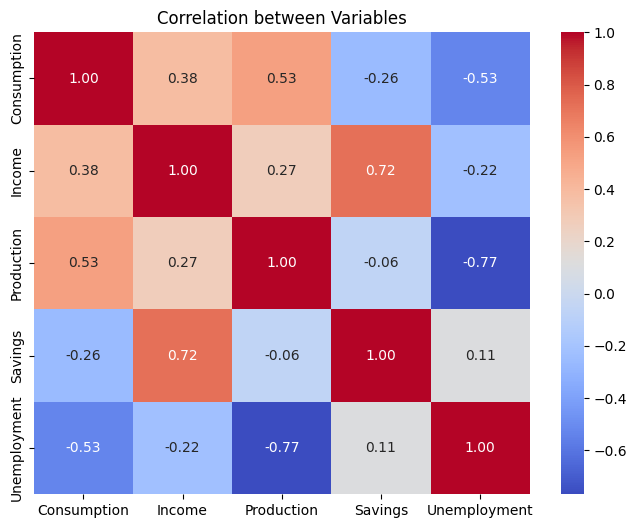

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(us_change.drop(columns=['Quarter']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Variables")
plt.show()

Aqui observamos que existe colinearidade entre `unemployment` e `production` e entre `savings` e `income`, o que faz todo sentido pelo contexto dos dados.

### Distribuições das Variáveis

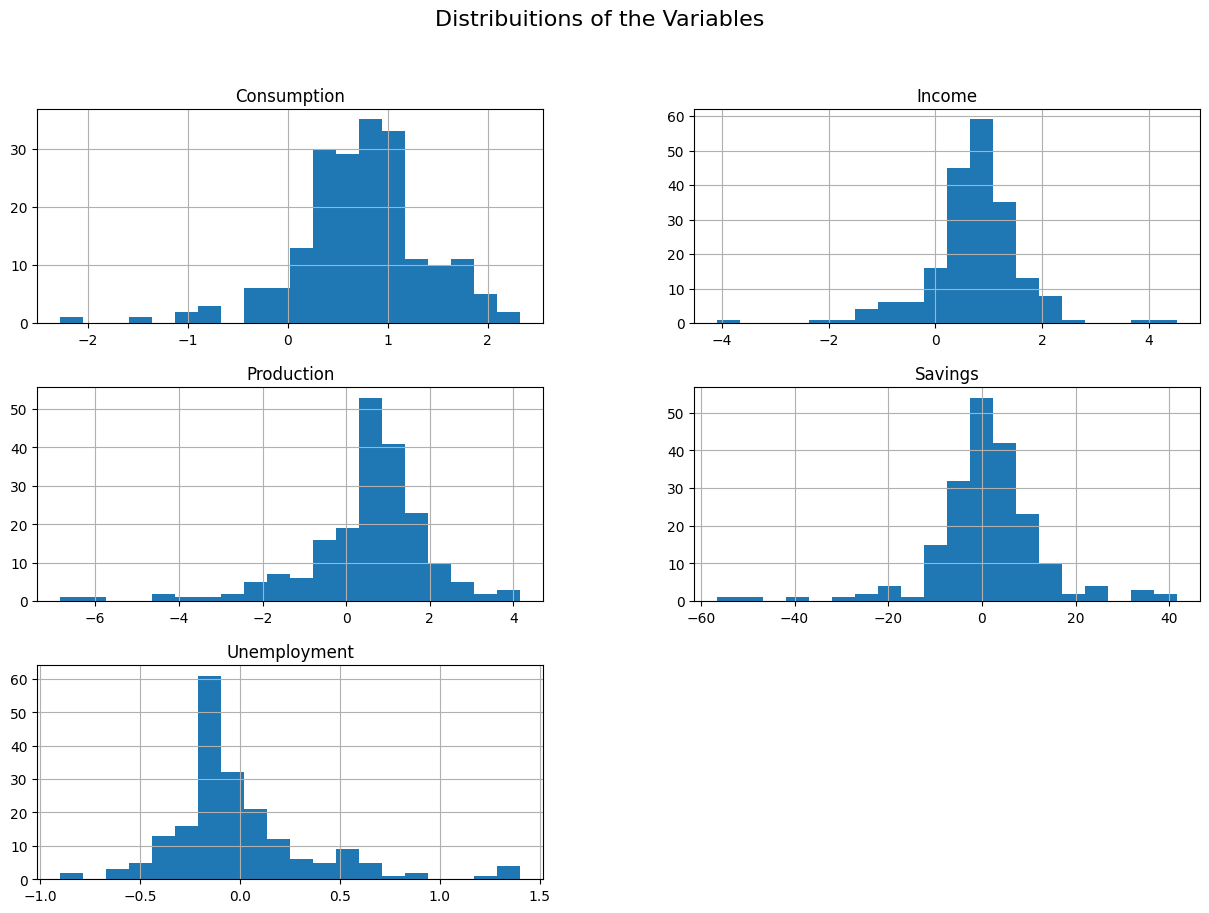

In [47]:
us_change.drop(columns=['Quarter']).hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribuitions of the Variables', fontsize=16)
plt.show()

### Função de Autocorrelação (ACF)

Vamos analisar a autocorrelação da variável `consumption` para identificar possíveis padrões de repetição.

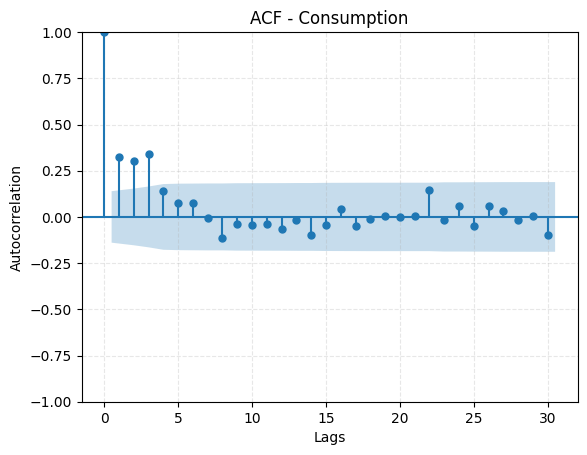

In [48]:
plot_acf(us_change['Consumption'], lags=30)
plt.grid(linestyle="--", alpha=0.3, zorder=5)
plt.title("ACF - Consumption")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

O gráfico revela valores elevados nos primeiros lags, indicando que há uma forte autocorrelação entre os valores atuais da série e os valores anteriores, ou seja, os valores da série temporal estão fortemente relacionados com os valores de períodos imediatamente anteriores.

### Verificação de Estacionariedade

In [49]:
# Teste de Dickey-Fuller aumentado (ADF)
from statsmodels.tsa.stattools import adfuller

result = adfuller(us_change['Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("\nA série 'Consumption' é estacionária.")
else:
    print("\nA série 'Consumption' não é estacionária.")

ADF Statistic: -4.610123
p-value: 0.000124
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575

A série 'Consumption' é estacionária.


### Decomposição da Série Temporal (STL)

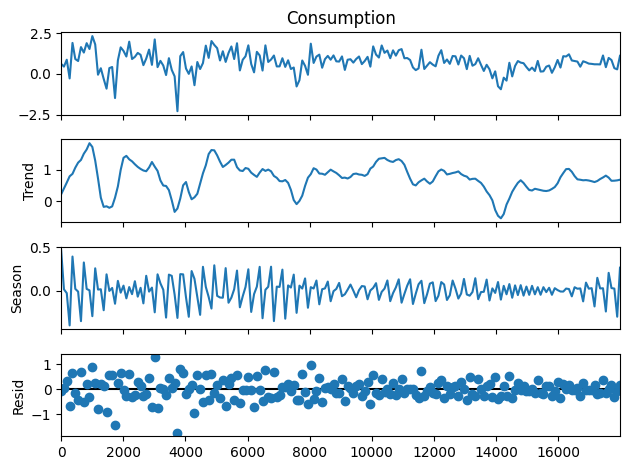

In [50]:
consumption_series = us_change.set_index('Quarter')['Consumption']
stl = STL(consumption_series, period=4, seasonal=13)

result = stl.fit()
result.plot()
plt.show()

A tendência da série é variável, enquanto a sazionalidade se mostra mais constante, seguindo alguns padrões ao longo do tempo. Já os resíduos apresentam alguns picos, mas se comportam bem em torno de 0.

## Divisão em Conjunto de Treinamento e Teste

In [51]:
train_size = int(len(us_change) * 0.8)
train, test = us_change.iloc[:train_size], us_change.iloc[train_size:]
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 158
Test size: 40


## Modelos Baseline

Vamos iniciar a modelagem de `consumption` utilizando modelos baseline, a fim de facilitar a interpretação inicial e compararmos posteriormente com modelos mais complexos.

In [52]:
# Function to plot forecast
def plot_forecast(model_pred, true_data, title='Forecast vs Actual'):
    plt.figure(figsize=(8, 4))
    plt.plot(true_data, label='Original', color='black', alpha=0.7)
    plt.plot(model_pred, label='Forecast', color='blue', linestyle='dashed')
    plt.title(title)
    plt.legend()
    plt.show()

### Mean Method
Prevê valores futuros com base na média da amostra observada.

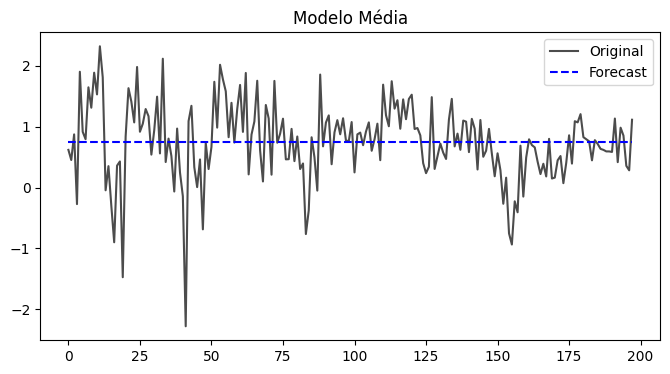

In [53]:
mean_forecast = [us_change['Consumption'].mean()] * len(us_change)

plot_forecast(mean_forecast, us_change['Consumption'], title='Modelo Média')


### Naïve Method (Random Walk)
O próximo valor é previsto como o último valor observado.

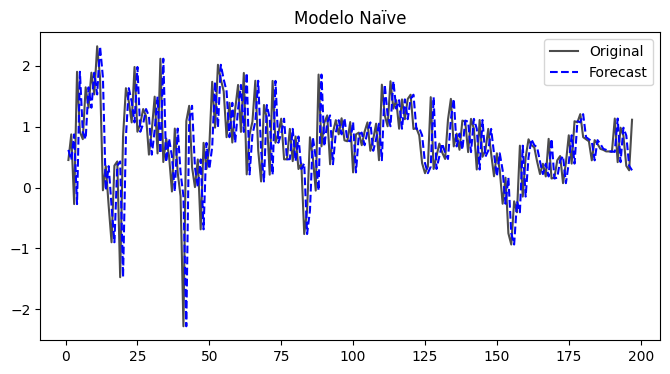

In [54]:
naive_forecast = us_change['Consumption'].shift(1).dropna()

plot_forecast(naive_forecast, us_change['Consumption'][1:], title='Modelo Naïve')


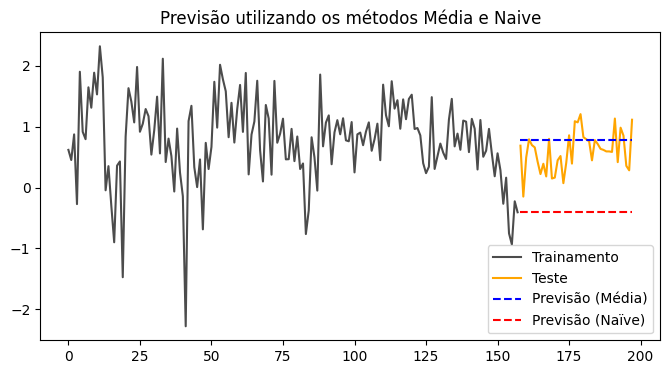

In [55]:
mean_forecast_series = [train['Consumption'].mean()] * len(test)
naive_forecast_series = train['Consumption'].iloc[-1]

mean_forecast_series = pd.Series(mean_forecast_series, index=test.index)
naive_forecast_series = pd.Series(naive_forecast_series, index=test.index)

plt.figure(figsize=(8,4))
plt.plot(train.index, train['Consumption'], label="Trainamento", color='black', alpha=0.7)
plt.plot(test.index, test['Consumption'], label="Teste", color='orange')
plt.plot(test.index, mean_forecast_series, label="Previsão (Média)", color='blue', linestyle='--')
plt.plot(test.index, naive_forecast_series, label="Previsão (Naïve)", color='red', linestyle='--')
plt.legend()
plt.title("Previsão utilizando os métodos Média e Naive")
plt.show()


In [56]:
def rmse(actual, forecast):
    return np.sqrt(np.mean((actual - forecast) ** 2))

mean_rmse = rmse(test['Consumption'], mean_forecast_series)
naive_rmse = rmse(test['Consumption'], naive_forecast_series)
print(f"RMSE do modelo da Média: {mean_rmse:.2f}")
print(f"RMSE do modelo Naïve: {naive_rmse:.2f}")

mean_mae = mean_absolute_error(test['Consumption'], mean_forecast_series)
naive_mae = mean_absolute_error(test['Consumption'], naive_forecast_series)
print(f"MAE do modelo da Média: {mean_mae:.2f}")
print(f"MAE do modelo Naïve: {naive_mae:.2f}")

mean_r2 = r2_score(test['Consumption'], mean_forecast_series)
naive_r2 = r2_score(test['Consumption'], naive_forecast_series)
print(f"R² do modelo da Média: {mean_r2:.2f}")
print(f"R² do modelo Naïve: {naive_r2:.2f}")

RMSE do modelo da Média: 0.36
RMSE do modelo Naïve: 1.05
MAE do modelo da Média: 0.29
MAE do modelo Naïve: 1.01
R² do modelo da Média: -0.32
R² do modelo Naïve: -10.47


### Análise de Resíduos

Análise de resíduos para o modelo da média

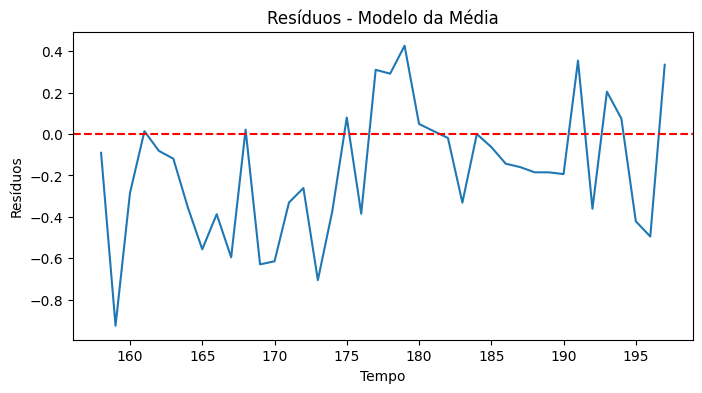

In [57]:
residuals_mean = test['Consumption'] - mean_forecast_series

plt.figure(figsize=(8, 4))
plt.plot(residuals_mean)
plt.title('Resíduos - Modelo da Média')
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='--')  # Linha horizontal em y=0
plt.show()

Análise de resíduos para o modelo Naive

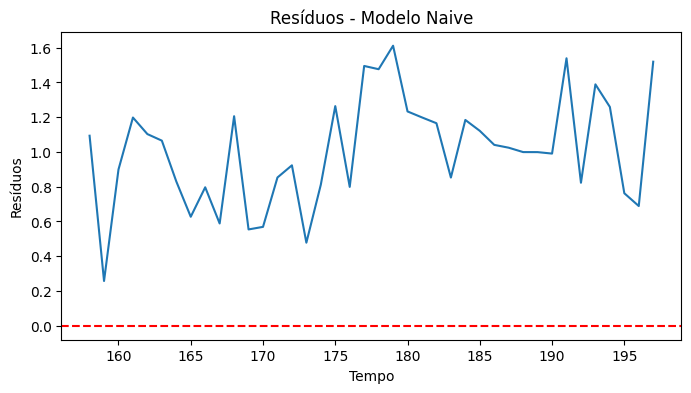

In [58]:
residuals_naive = test['Consumption'] - naive_forecast_series

plt.figure(figsize=(8, 4))
plt.plot(residuals_naive)
plt.title('Resíduos - Modelo Naive')
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Modelos de Suavização Exponencial

A suavização exponencial atribui um peso maior aos valores mais recentes da série temporal, utilizando pesos exponencialmente decrescentes para observações passadas, o que a torna eficiente para capturar padrões e tendências em dados de séries temporais.

### Suavização Exponencial Simples
A suavização exponencial simples é útil quando não há tendência ou sazonalidade na série temporal. Ela prevê os valores futuros com base em uma média ponderada dos valores passados, onde os pesos diminuem exponencialmente à medida que os valores se afastam do presente.

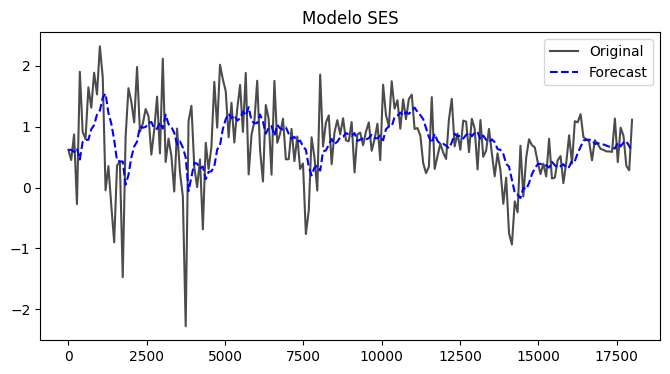

In [59]:
ses_model = SimpleExpSmoothing(consumption_series).fit(smoothing_level=0.2, optimized=True)
ses_forecast = ses_model.fittedvalues

plt.figure(figsize=(8, 4))
plt.plot(consumption_series, label='Original', color='black', alpha=0.7)
plt.plot(ses_forecast, label='Forecast', color='blue', linestyle='dashed')
plt.legend()
plt.title('Modelo SES')
plt.show()

### Suavização Exponencial Aditiva
A suavização exponencial aditiva é apropriada para séries temporais com **tendência linear** e **sazonalidade aditiva**. O modelo ajusta o nível da série com base em um componente de tendência e sazonalidade, que são somados à previsão.

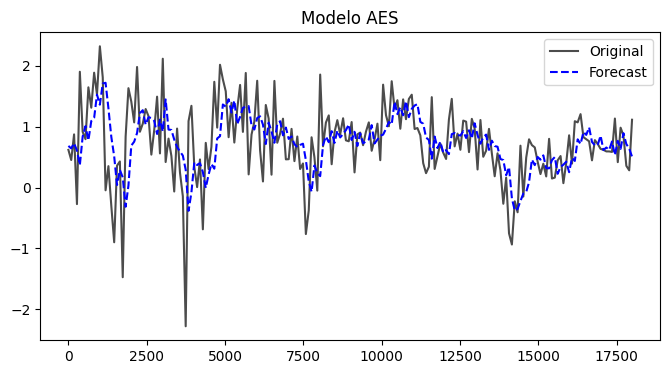

In [60]:
aes_model = ExponentialSmoothing(consumption_series, trend='add', seasonal='add', seasonal_periods=4).fit()
aes_forecast = aes_model.fittedvalues

plt.figure(figsize=(8, 4))
plt.plot(consumption_series, label='Original', color='black', alpha=0.7)
plt.plot(aes_forecast, label='Forecast', color='blue', linestyle='dashed')
plt.legend()
plt.title('Modelo AES')
plt.show()

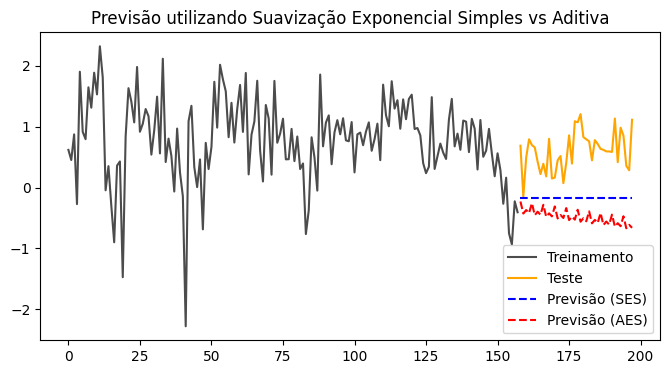

In [61]:
ses_model = SimpleExpSmoothing(train['Consumption']).fit(smoothing_level=0.2, optimized=True)
ses_forecast = ses_model.forecast(len(test))

holt_winters_model = ExponentialSmoothing(train['Consumption'], trend='add', seasonal='add', seasonal_periods=4).fit()
holt_winters_forecast = holt_winters_model.forecast(len(test))

plt.figure(figsize=(8,4))
plt.plot(train.index, train['Consumption'], label="Treinamento", color='black', alpha=0.7)
plt.plot(test.index, test['Consumption'], label="Teste", color='orange')
plt.plot(test.index, ses_forecast, label="Previsão (SES)", color='blue', linestyle='dashed')
plt.plot(test.index, holt_winters_forecast, label="Previsão (AES)", color='red', linestyle='dashed')

plt.legend()
plt.title("Previsão utilizando Suavização Exponencial Simples vs Aditiva")
plt.show()

In [62]:
ses_rmse = rmse(test['Consumption'], ses_forecast)
holt_winters_rmse = rmse(test['Consumption'], holt_winters_forecast)

ses_mae = mean_absolute_error(test['Consumption'], ses_forecast)
holt_winters_mae = mean_absolute_error(test['Consumption'], holt_winters_forecast)

ses_r2 = r2_score(test['Consumption'], ses_forecast)
holt_winters_r2 = r2_score(test['Consumption'], holt_winters_forecast)

print("SES Model")
print(f"RMSE: {ses_rmse:.2f}")
print(f"MAE: {ses_mae:.2f}")
print(f"R²: {ses_r2:.2f}")

print("\nAES Model")
print(f"RMSE: {holt_winters_rmse:.2f}")
print(f"MAE: {holt_winters_mae:.2f}")
print(f"R²: {holt_winters_r2:.2f}")

SES Model
RMSE: 0.84
MAE: 0.77
R²: -6.20

AES Model
RMSE: 1.14
MAE: 1.08
R²: -12.41


Como verificamos anteriormente, a série temporal não possui uma tendência clara, portanto os métodos de Suavização Exponencial não são ideais e não apresentaram bom desempenho.

## Modelos de Regressão Linear Múltipla

In [63]:
# Select predictors and target variable
predictors = ['Income', 'Savings', 'Production', 'Unemployment']
X = us_change[predictors]
y = us_change['Consumption']

# Train and test split
test_size = 40
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

In [64]:
# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions in test set
y_pred = model.predict(X_test)

# Model coefficients
coefficients = pd.DataFrame({'Variable': predictors, 'Coefficient': model.coef_})
print(coefficients)


       Variable  Coefficient
0        Income     0.727840
1       Savings    -0.050568
2    Production     0.042362
3  Unemployment    -0.229071


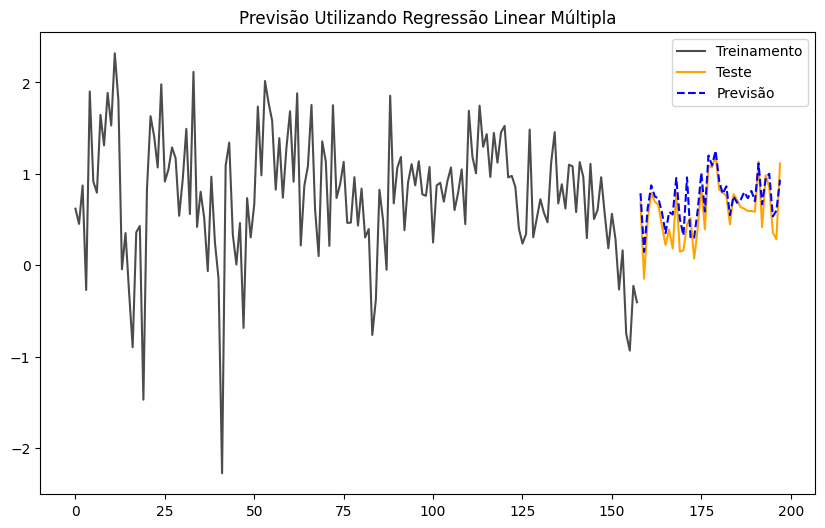

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Treinamento', color='black', alpha=0.7)
plt.plot(y_test.index, y_test, label='Teste', color='orange')
plt.plot(y_test.index, y_pred, label='Previsão', color='blue', linestyle='dashed')

plt.title("Previsão Utilizando Regressão Linear Múltipla")
plt.legend()
plt.show()

In [66]:
lr_rmse = mean_squared_error(y_test, y_pred, squared=False)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R²: {lr_r2:.2f}")

RMSE: 0.19
MAE: 0.15
R²: 0.64


### Transformação de Variáveis

Vamos testar uma transformação logarítimica na variável `savings` utilizando Log-Sign Transformation (existem valores positivos e negativos).

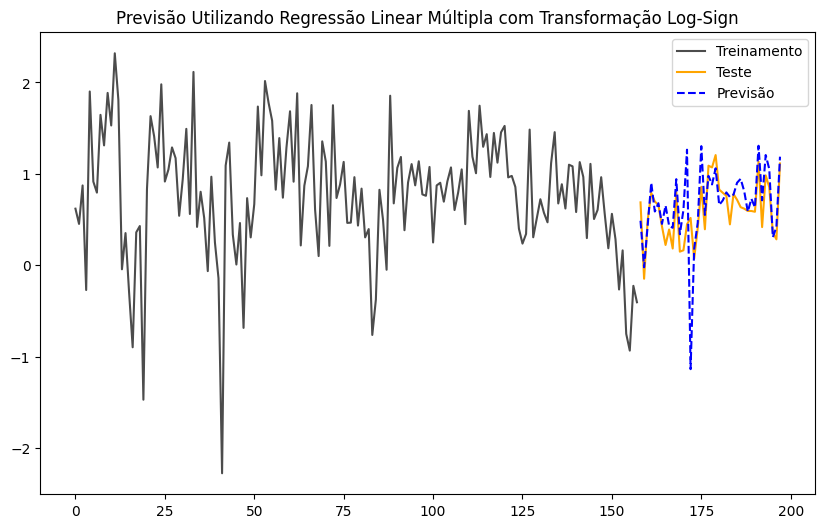

In [67]:
# Log-Sign
us_change['Savings_transformed'] = np.sign(us_change['Savings']) * np.log(np.abs(us_change['Savings']) + 1)

predictors_transformed = ["Income", "Production", "Savings_transformed", 'Unemployment']
X_transformed = us_change[predictors_transformed]
y_transformed = us_change['Consumption']

X_train_transformed, X_test_transformed = X_transformed[:-test_size], X_transformed[-test_size:]
y_train_transformed, y_test_transformed = y_transformed[:-test_size], y_transformed[-test_size:]

model_transformed = LinearRegression()
model_transformed.fit(X_train_transformed, y_train_transformed)
y_pred_transformed = model_transformed.predict(X_test_transformed)

plt.figure(figsize=(10, 6))
plt.plot(y_train_transformed.index, y_train_transformed, label='Treinamento', color='black', alpha=0.7)
plt.plot(y_test_transformed.index, y_test_transformed, label='Teste', color='orange')
plt.plot(y_test_transformed.index, y_pred_transformed, label='Previsão', color='blue', linestyle='dashed')

plt.title("Previsão Utilizando Regressão Linear Múltipla com Transformação Log-Sign")
plt.legend()
plt.show()

In [68]:
rmse_transformed = np.sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
mae_transformed = mean_absolute_error(y_test_transformed, y_pred_transformed)
r2_transformed = r2_score(y_test_transformed, y_pred_transformed)

print(f"RMSE (Transformado): {rmse_transformed:.2f}")
print(f"MAE (Transformado): {mae_transformed:.2f}")
print(f"R² (Transformado): {r2_transformed:.2f}")

RMSE (Transformado): 0.35
MAE (Transformado): 0.21
R² (Transformado): -0.25


Essa transformação não trouxe ganhos de performance para o modelo de regressão linear.


## Modelos SARIMA

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Preparação dos Dados e Análise Exploratória

Primeiramente, separamos a variável `Consumption` do dataset para utilizá-la na modelagem. Dividimos os dados em treinamento (90%) e teste (10%) e, em seguida, aplicamos uma diferença para tornar a série temporal estacionária. Realizamos também a análise de autocorrelação (ACF) e autocorrelação parcial (PACF) para identificar os parâmetros adequados para o modelo SARIMA.

Os gráficos de ACF e PACF nos ajudam a identificar a ordem dos parâmetros \( p \) e \( q \) da parte autoregressiva (AR) e da média móvel (MA) do modelo. O comportamento dessas funções orienta a escolha desses parâmetros.

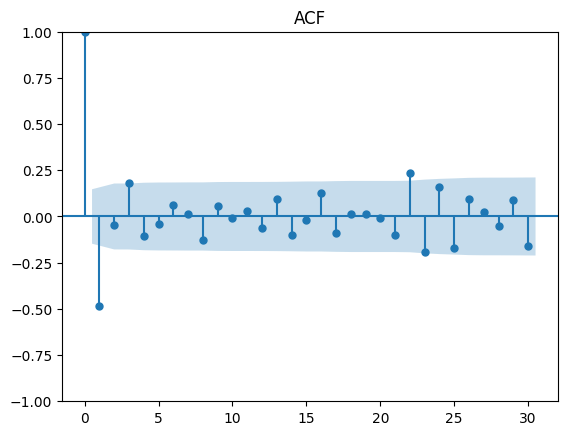

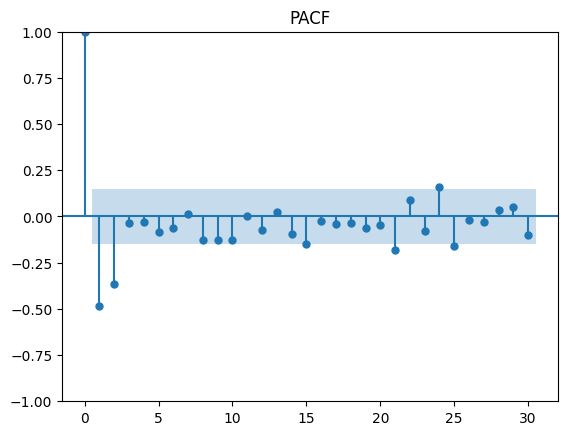

In [70]:
data = us_change[['Consumption']]

train_size = int(len(data) * 0.9)

# Dividir os dados
train = data[:train_size]
test = data[train_size:]

data_diff = train.diff().dropna()

plot_acf(data_diff, lags=30)
plt.title("ACF")
plt.show()

plot_pacf(data_diff, lags=30)
plt.title("PACF")
plt.show()

### Ajuste do Modelo SARIMA

Com base nas observações dos gráficos de ACF e PACF, definimos os parâmetros do modelo SARIMA como \( p = 1 \), \( d = 1 \), \( q = 2 \), \( P = 1 \), \( D = 1 \), \( Q = 1 \) e \( S = 12 \) (sazonalidade anual). Em seguida, ajustamos o modelo SARIMA aos dados de treinamento.

O modelo foi ajustado utilizando a classe `SARIMAX` da biblioteca `statsmodels` e a tabela de resultados exibiu informações relevantes como AIC e BIC, que foram usadas para avaliar a adequação do modelo.

In [71]:
# Definir os parâmetros do modelo
p, d, q = 1, 1, 2
P, D, Q, S = 1, 1, 1, 12

# Ajustar o modelo SARIMA
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S),
                enforce_stationarity=False, enforce_invertibility=False)

sarima_results = model.fit()
print(sarima_results.summary())

print(f'AIC: {sarima_results.aic}')
print(f'BIC: {sarima_results.bic}')

                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  178
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -144.806
Date:                              Wed, 27 Nov 2024   AIC                            301.612
Time:                                      03:19:32   BIC                            319.676
Sample:                                           0   HQIC                           308.951
                                              - 178                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3869      0.432     -0.895      0.371      -1.234       0.460
ma.L1         -0.21

### Previsões e Intervalos de Confiança

Após ajustar o modelo, realizamos previsões para o período de teste. Para isso, geramos tanto as previsões pontuais quanto os intervalos de confiança. As previsões são comparadas com os dados reais de teste para avaliar a precisão do modelo. A visualização dos resultados inclui os dados de treinamento, os dados de teste e as previsões do modelo, com a área sombreada representando o intervalo de confiança das previsões.

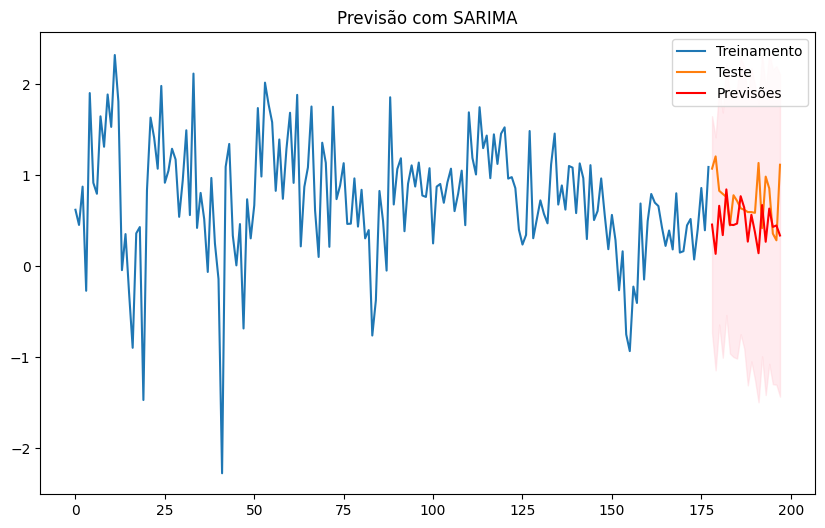

In [72]:
# Fazer previsões para o período de teste
forecast = sarima_results.get_forecast(steps=len(test))

# Obter os valores previstos
forecast_values = forecast.predicted_mean

# Intervalo de confiança
forecast_ci = forecast.conf_int()

# Visualizar as previsões
plt.figure(figsize=(10, 6))
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(forecast_values, label='Previsões', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Previsão com SARIMA')
plt.show()


### Análise do Modelo
#### Avaliação com Métricas:

Para avaliar a performance do modelo, utilizamos duas métricas principais: o erro quadrático médio (RMSE) e o erro absoluto médio (MAE). O RMSE penaliza mais fortemente grandes erros, enquanto o MAE dá uma visão mais simples do erro médio, sem dar tanto peso aos valores extremos. Ambas as métricas foram calculadas utilizando os dados de teste e as previsões geradas pelo modelo.

In [73]:
rmse = np.sqrt(mean_squared_error(test, forecast_values))
mae = mean_absolute_error(test, forecast_values)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.46648235105363917
MAE: 0.3446487917081548


#### Análise dos Resíduos

Uma parte importante da avaliação do modelo SARIMA envolve a análise dos resíduos. Os resíduos são a diferença entre os valores observados e as previsões feitas pelo modelo. Se o modelo estiver bem ajustado, os resíduos devem se comportar como ruído branco, ou seja, não devem apresentar autocorrelação significativa e devem ter distribuição normal.

Primeiro, os resíduos foram visualizados em um gráfico para observar sua distribuição ao longo do tempo. Em seguida, realizamos o teste de Ljung-Box para verificar a autocorrelação dos resíduos e confirmamos que os resíduos não apresentam autocorrelação significativa. A função de autocorrelação dos resíduos também foi analisada para garantir que não existam padrões não capturados pelo modelo.

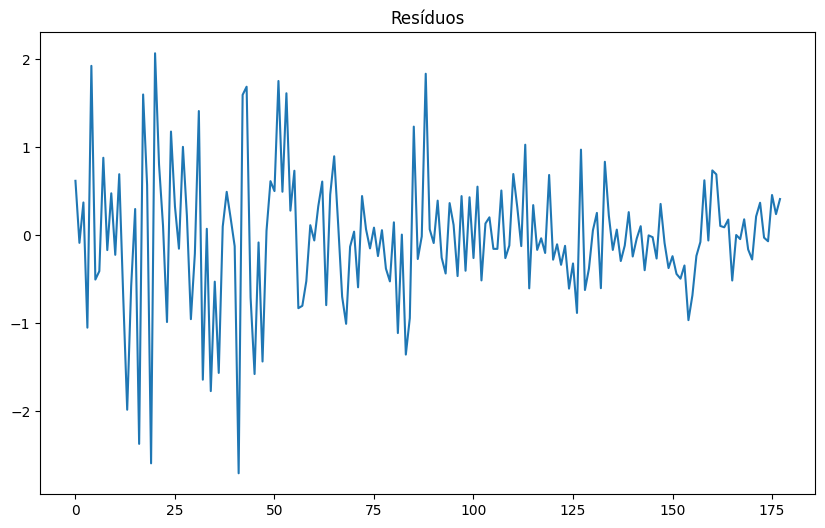

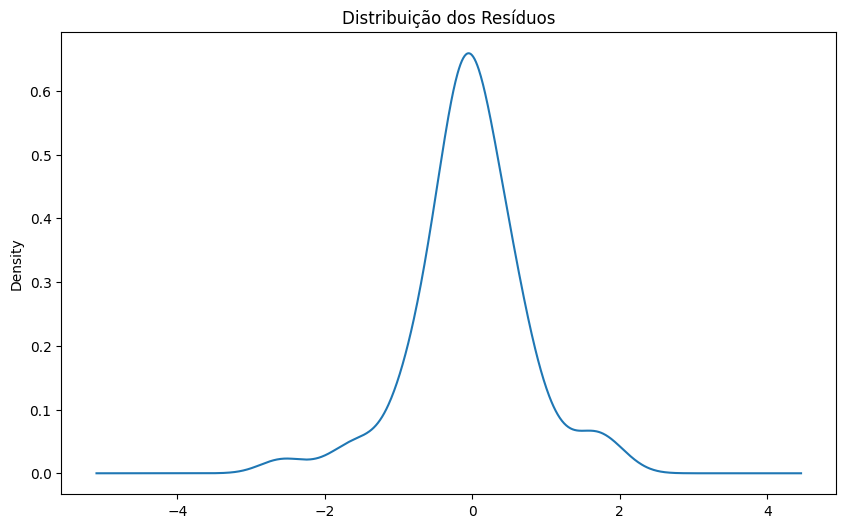

      lb_stat  lb_pvalue
10  21.526512   0.017707


<Figure size 1000x600 with 0 Axes>

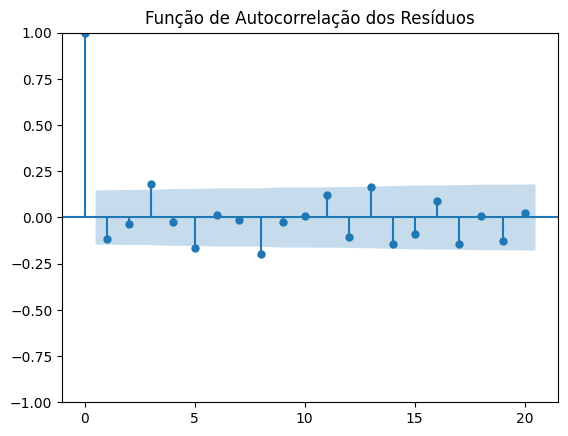

In [74]:
residuals = sarima_results.resid

# Plotar os resíduos
residuals.plot(figsize=(10, 6))
plt.title('Resíduos')
plt.show()

# Histograma dos resíduos
residuals.plot(kind='kde', figsize=(10, 6))
plt.title('Distribuição dos Resíduos')
plt.show()

# Testar se os resíduos são ruído branco
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

# Plotar a função de autocorrelação dos resíduos para mais lags
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=20)  # Você pode ajustar o número de lags conforme necessário
plt.title('Função de Autocorrelação dos Resíduos')
plt.show()

## Modelos de Convolução 1D

In [75]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R²": r2}

sequence_length = 4  # Número de lags
X, y = [], []

# Gerar lags para séries temporais
for i in range(len(us_change) - sequence_length):
    X.append(us_change.iloc[i:i+sequence_length]['Consumption'].values)
    y.append(us_change.iloc[i+sequence_length]['Consumption'])

X = np.array(X)
y = np.array(y)

# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Reformatar para entrada 1D do modelo CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model_cnn.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_split=0.1)

# Previsões
y_pred_train = model_cnn.predict(X_train).flatten()
y_pred_test = model_cnn.predict(X_test).flatten()



Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2677 - mae: 0.9722 - val_loss: 1.3647 - val_mae: 1.0667
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0432 - mae: 0.8815 - val_loss: 1.1694 - val_mae: 0.9742
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8227 - mae: 0.7491 - val_loss: 0.9964 - val_mae: 0.8818
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7449 - mae: 0.7092 - val_loss: 0.8437 - val_mae: 0.7910
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6389 - mae: 0.6583 - val_loss: 0.7104 - val_mae: 0.7090
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5374 - mae: 0.5770 - val_loss: 0.6029 - val_mae: 0.6340
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5236 - mae: 0.5512 - val_loss: 0.5210 - val_mae: 0.5757
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4056 - mae: 0.4828 - val_loss: 0.4694 - val_mae: 0.5421
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4395 - mae: 0.4677 - val_loss

In [76]:
# Metrics
cnn_metrics_train = calculate_metrics(y_train, y_pred_train)
cnn_metrics_test = calculate_metrics(y_test, y_pred_test)

print("Métricas no Treinamento:", cnn_metrics_train)
print("Métricas no Teste:", cnn_metrics_test)



Métricas no Treinamento: {'RMSE': 0.6195298237043565, 'MAE': 0.45532161888743067, 'R²': 0.08199913827232597}
Métricas no Teste: {'RMSE': 0.5743314862226687, 'MAE': 0.42572276221421973, 'R²': 0.08205168773579696}


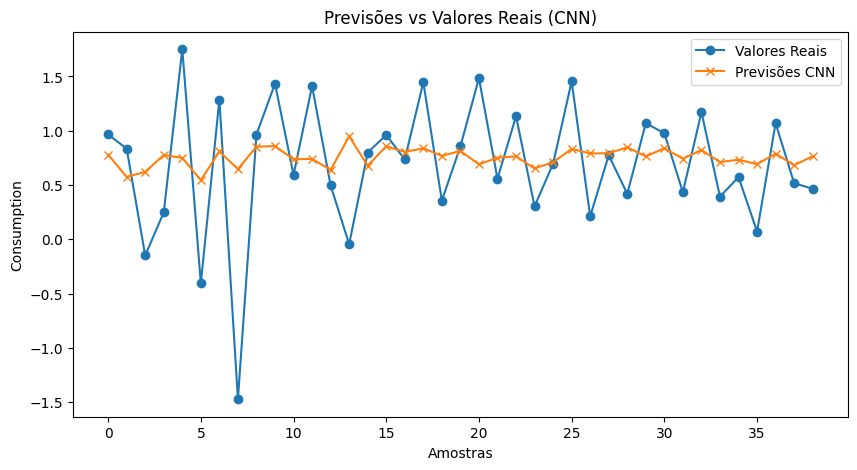

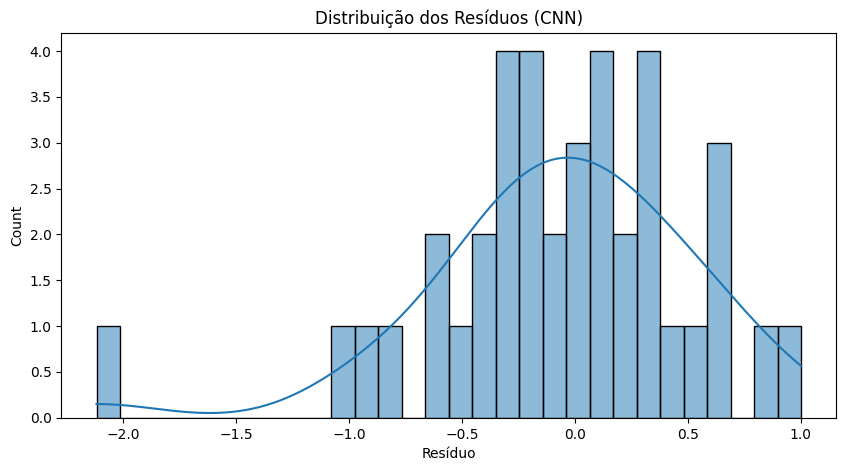

In [77]:
# Visualização dos resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valores Reais', marker='o')
plt.plot(y_pred_test, label='Previsões CNN', marker='x')
plt.legend()
plt.title('Previsões vs Valores Reais (CNN)')
plt.xlabel('Amostras')
plt.ylabel('Consumption')
plt.show()

# Visualização dos resíduos
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribuição dos Resíduos (CNN)")
plt.xlabel("Resíduo")
plt.show()


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8717 - mae: 0.7933 - val_loss: 0.9704 - val_mae: 0.8562
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6886 - mae: 0.6681 - val_loss: 0.7611 - val_mae: 0.7313
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6931 - mae: 0.6422 - val_loss: 0.6027 - val_mae: 0.6263
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4363 - mae: 0.4922 - val_loss: 0.5098 - val_mae: 0.5552
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4121 - mae: 0.4863 - val_loss: 0.4702 - val_mae: 0.5227
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3655 - mae: 0.4480 - val_loss: 0.4626 - val_mae: 0.5173
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4459 - mae: 0.4822 - val_loss: 0.4664 - val_mae: 0.5204
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3925 - mae: 0.4619 - val_loss: 0.4744 - val_mae: 0.5281
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5136 - mae: 0.5215 - val_loss

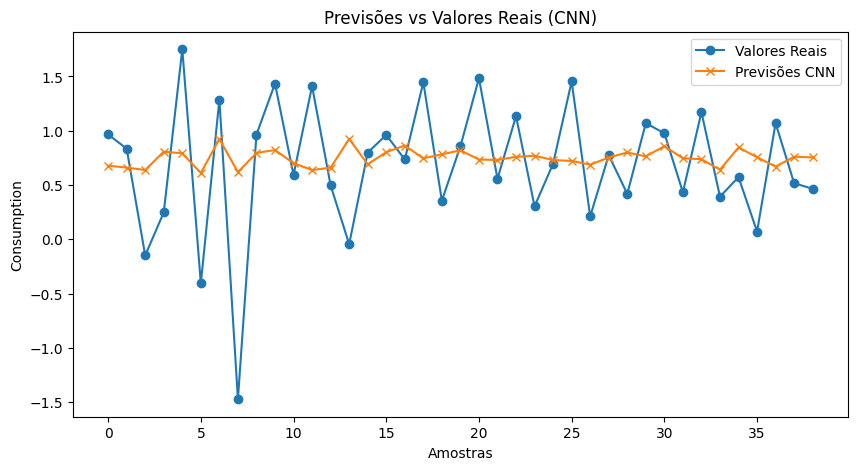

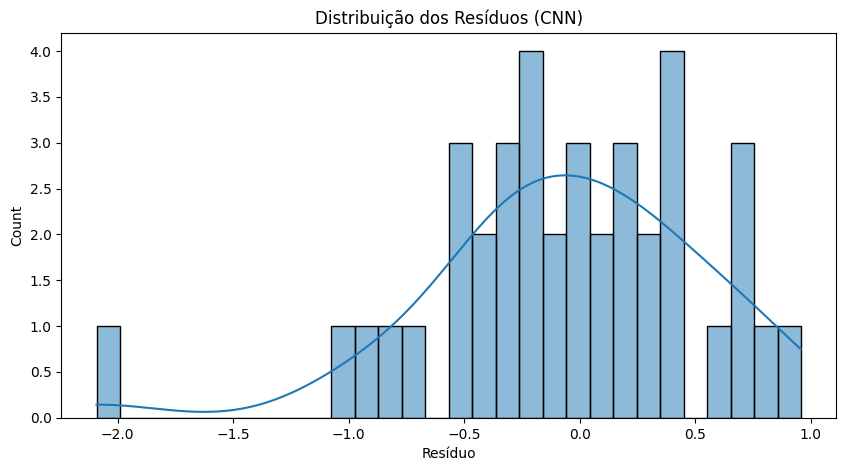

In [78]:
# Gerar lags para séries temporais multivariadas
sequence_length = 4  # Número de lags
X, y = [], []

for i in range(len(us_change) - sequence_length):
    # Usar todas as variáveis independentes (Income, Production, Savings, Unemployment) como entrada
    X.append(us_change.iloc[i:i+sequence_length][['Income', 'Production', 'Savings', 'Unemployment']].values)
    y.append(us_change.iloc[i+sequence_length]['Consumption'])

X = np.array(X)
y = np.array(y)

# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Reformatar para entrada 1D do modelo CNN
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo CNN atualizado
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinamento
history = model_cnn.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_split=0.1)

# Previsões
y_pred_train = model_cnn.predict(X_train).flatten()
y_pred_test = model_cnn.predict(X_test).flatten()

# Métricas
cnn_metrics_train = calculate_metrics(y_train, y_pred_train)
cnn_metrics_test = calculate_metrics(y_test, y_pred_test)

print("Métricas no Treinamento:", cnn_metrics_train)
print("Métricas no Teste:", cnn_metrics_test)

# Visualização dos resultados
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valores Reais', marker='o')
plt.plot(y_pred_test, label='Previsões CNN', marker='x')
plt.legend()
plt.title('Previsões vs Valores Reais (CNN)')
plt.xlabel('Amostras')
plt.ylabel('Consumption')
plt.show()

# Visualização dos resíduos
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribuição dos Resíduos (CNN)")
plt.xlabel("Resíduo")
plt.show()


## Modelos RNN como LSTM

In [79]:
# Scale the data before feeding it into the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_consumption = scaler.fit_transform(us_change['Consumption'].values.reshape(-1, 1))

# Create data structure for LSTM [samples, time steps, features]
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12

# Prepare the data for training
X, y = create_dataset(scaled_consumption, time_step)

# Reshape X to be 3D [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.3900 - val_loss: 0.2043
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1920 - val_loss: 0.0627
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0527 - val_loss: 0.0055
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0313 - val_loss: 0.0213
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0461 - val_loss: 0.0056
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0260 - val_loss: 0.0088
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0271 - val_loss: 0.0119
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0249 - val_loss: 0.0089
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0216 - val_loss: 0.0054
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0235 - val_loss: 0.0049
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0263 - val_loss: 0.0048
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0197 - val_loss: 0.0050


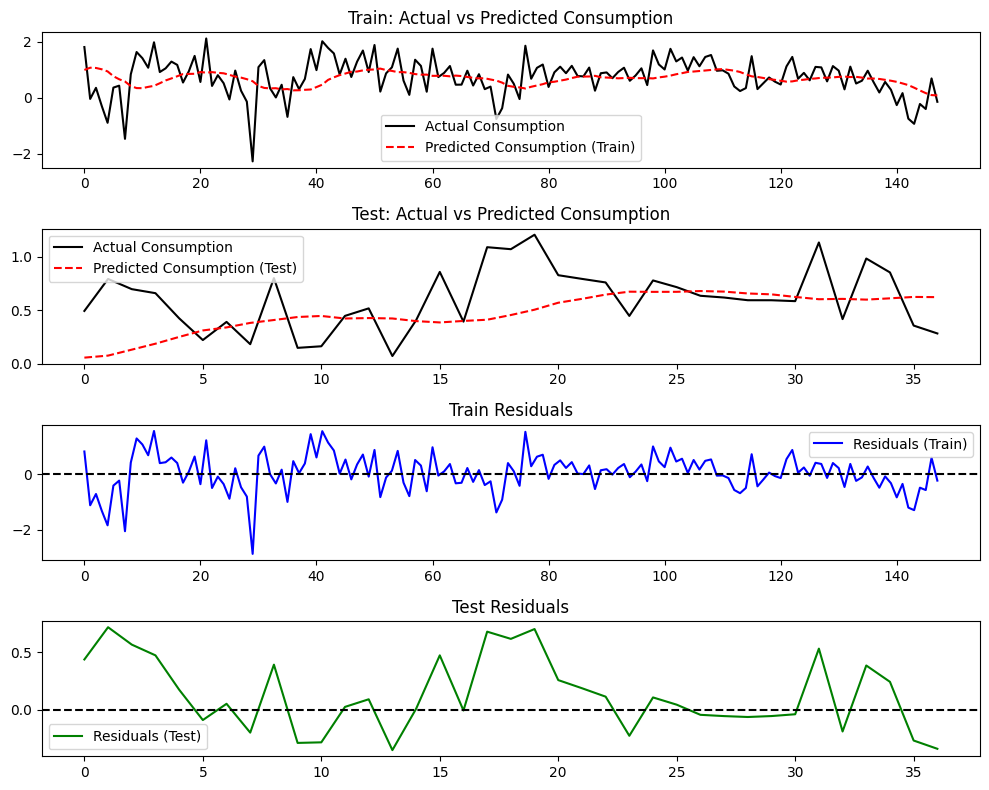

In [80]:
# Plotting Results with Residuals
plt.figure(figsize=(10, 8))

# Training data plot
plt.subplot(4, 1, 1)
plt.plot(y_train_actual, label='Actual Consumption', color='black')
plt.plot(train_predict, label='Predicted Consumption (Train)', color='red', linestyle='dashed')
plt.legend()
plt.title('Train: Actual vs Predicted Consumption')

# Test data plot
plt.subplot(4, 1, 2)
plt.plot(y_test_actual, label='Actual Consumption', color='black')
plt.plot(test_predict, label='Predicted Consumption (Test)', color='red', linestyle='dashed')
plt.legend()
plt.title('Test: Actual vs Predicted Consumption')

# Residuals plot for Train set
train_residuals = y_train_actual - train_predict
plt.subplot(4, 1, 3)
plt.plot(train_residuals, label='Residuals (Train)', color='blue')
plt.axhline(y=0, color='black', linestyle='--')  # Line at 0 for reference
plt.legend()
plt.title('Train Residuals')

# Residuals plot for Test set
test_residuals = y_test_actual - test_predict
plt.subplot(4, 1, 4)
plt.plot(test_residuals, label='Residuals (Test)', color='green')
plt.axhline(y=0, color='black', linestyle='--')  # Line at 0 for reference
plt.legend()
plt.title('Test Residuals')

plt.tight_layout()
plt.show()



In [81]:
# Metrics

lstm_metrics_train = calculate_metrics(y_train_actual, train_predict)
lstm_metrics_test = calculate_metrics(y_test_actual, test_predict)

print("Métricas no Treinamento:", lstm_metrics_train)
print("Métricas no Teste:", lstm_metrics_test)


Métricas no Treinamento: {'RMSE': 0.6766607408093942, 'MAE': 0.5092925035185604, 'R²': 0.006420446589786466}
Métricas no Teste: {'RMSE': 0.3380717327562542, 'MAE': 0.26371088086249267, 'R²': -0.38949185916387585}
